# Mean-Reversion

## Data Cleaning

Prior to diving into the strategy itself, we will gather the required data. I am using the Coingecko API as my Velodata access is limited and I am not able to get the required 365 days historic data.

In [26]:
import polars as pl
import pycoingecko
import matplotlib.pyplot as plt

cg = pycoingecko.CoinGeckoAPI()

coin_list = ['aptos', 'arbitrum', 'avalanche-2', 'binancecoin', 'bitcoin-cash', 'bitcoin', 'bonk', 'cardano', 'celestia', 'chainlink', 'cosmos', 'dogecoin', 'dogwifcoin', 'ethereum', 'floki', 'injective-protocol', 'litecoin', 'matic-network', 'near', 'notcoin', 'optimism', 'pepe', 'polkadot', 'ripple', 'shiba-inu', 'solana', 'sui', 'the-open-network', 'thorchain', 'tron']
load = 0

if load:
    for coin in coin_list:
        data = cg.get_coin_market_chart_by_id(coin, 'usd', 365)
        df_coin = (pl.DataFrame(data['prices'], strict=False)
                .transpose()
                .with_columns(pl.lit(coin).alias('ticker'), 
                                pl.all().cast(pl.String))
                )
        df_coin.write_csv(f"./data/{coin}.csv")

Next, we combine and clean up the dataframe.

In [27]:
try:
    df = (
        pl.scan_csv(f"./data/*.csv", infer_schema_length=0).with_columns(
            pl.from_epoch(pl.col('column_0').cast(pl.Float32), time_unit='ms').alias('timestamp'),
            pl.col('column_1').cast(pl.Float32).alias('price')
        ).drop(
            ['column_0', 'column_1']
        )
    )
except pl.exceptions.ComputeError as e:
    raise(e)

df = df.collect()

# round the timestamp
df = df.with_columns(
    pl.col('timestamp').dt.date()
).sort(['timestamp'])

## Exploratory Data Analysis

### Data Gaps

Next, we will take a look at tokens where a significant amount of data is missing. Unsurprisingly, Notcoin, DogWifHat and Celestia do not have a full year of data.

In [28]:
df.group_by('ticker').agg(pl.len()).sort('len').head(10)

ticker,len
str,u32
"""notcoin""",87
"""dogwifcoin""",243
"""celestia""",286
"""the-open-network""",365
"""injective-protocol""",365
"""polkadot""",365
"""bitcoin-cash""",365
"""litecoin""",365
"""dogecoin""",365


### Strategy

The strategy that we will be looking at is pair-trading which will make use of longing and shorting an asset at the same time. Essentially, we are trying to long/short the ratio between the two assets. As a start, we will look at correlations amongst the prices.

In [29]:
# pivot table
df_prices_pivot = df.pivot(index='timestamp', values='price', on='ticker', aggregate_function='first')

# remove coins & rows where there is no data
df_prices_pivot = df_prices_pivot.drop(['celestia', 'notcoin', 'dogwifcoin'])

# drop rows with null values
df_prices_pivot = df_prices_pivot.drop_nulls()

df_prices_pivot

timestamp,aptos,arbitrum,avalanche-2,binancecoin,bitcoin-cash,bitcoin,bonk,cardano,chainlink,cosmos,dogecoin,ethereum,floki,injective-protocol,litecoin,matic-network,near,optimism,pepe,polkadot,ripple,shiba-inu,solana,sui,the-open-network,thorchain,tron
date,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
2023-08-11,7.09712,1.157507,12.440173,239.595825,228.957672,29396.847656,3.3980e-7,0.293325,7.48495,8.361043,0.075714,1847.54187,0.000023,7.629209,83.508011,0.680381,1.332544,1.586289,0.000001,5.002863,0.631618,0.00001,24.579809,0.604815,1.299681,1.141432,0.077129
2023-08-13,7.203747,1.162308,12.385306,240.08844,228.588776,29412.142578,3.4049e-7,0.291666,7.437998,8.412474,0.076696,1848.505249,0.000023,7.658162,83.399574,0.681371,1.341807,1.551729,0.000001,5.032357,0.627081,0.000011,24.891819,0.607752,1.369081,1.270709,0.077442
2023-08-14,7.058094,1.140614,12.259066,240.030792,228.387161,29284.96875,3.3536e-7,0.289372,7.368214,8.369781,0.074778,1839.512817,0.000023,7.710098,81.946228,0.677199,1.342449,1.538776,0.000001,4.984807,0.625689,0.00001,24.223293,0.597759,1.399275,1.384983,0.077098
2023-08-15,7.065962,1.140783,12.352482,240.358063,230.119965,29400.585938,3.3180e-7,0.290452,7.411531,8.501039,0.074764,1843.513428,0.000024,7.566969,82.043495,0.679426,1.334398,1.532508,0.000001,4.986299,0.634681,0.00001,25.147724,0.599196,1.436982,1.466519,0.077408
2023-08-16,6.180421,1.048851,11.371465,232.09549,208.303879,28754.197266,3.0801e-7,0.274852,6.759309,7.798525,0.067312,1809.460449,0.000021,7.054157,74.44278,0.623792,1.210604,1.404876,0.000001,4.664406,0.589253,0.000009,22.846367,0.526011,1.403133,1.447245,0.074736
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-08-05,5.315245,0.565038,21.19626,495.964294,331.22879,58006.207031,0.00002,0.34344,10.860103,5.028977,0.103636,2682.4375,0.000122,17.656378,62.269962,0.420127,4.12852,1.328733,0.000008,4.67678,0.523,0.000013,137.555038,0.574489,6.003661,3.19694,0.126105
2024-08-06,5.120536,0.501634,20.853849,483.581482,314.334198,55959.839844,0.00002,0.330263,10.04457,4.892992,0.096302,2455.511475,0.000121,15.989698,58.175426,0.407737,3.666157,1.273265,0.000008,4.503072,0.504587,0.000013,143.643417,0.600597,5.748909,3.111152,0.123343
2024-08-08,5.073907,0.484551,19.852839,474.915161,312.404633,55099.953125,0.000019,0.323784,9.494531,4.837174,0.095642,2341.590332,0.000118,14.909516,56.01646,0.391942,3.570969,1.197697,0.000007,4.5672,0.604712,0.000013,145.142456,0.61584,5.437376,2.939726,0.124707


In [30]:
# pairwise correlations
df_prices_pivot.drop('timestamp').corr()

aptos,arbitrum,avalanche-2,binancecoin,bitcoin-cash,bitcoin,bonk,cardano,chainlink,cosmos,dogecoin,ethereum,floki,injective-protocol,litecoin,matic-network,near,optimism,pepe,polkadot,ripple,shiba-inu,solana,sui,the-open-network,thorchain,tron
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.700583,0.872619,0.463793,0.612312,0.607859,0.551304,0.855086,0.774206,0.826485,0.714041,0.621146,0.518979,0.785233,0.811676,0.820989,0.617439,0.825885,0.25917,0.905304,0.460752,0.691893,0.635151,0.845386,0.143354,0.844942,0.506615
0.700583,1.0,0.645421,-0.018928,0.064228,0.173233,0.17173,0.773072,0.661594,0.828864,0.172777,0.238443,-0.027934,0.778453,0.357306,0.854021,0.161213,0.905793,-0.218239,0.73719,0.371956,0.173898,0.213459,0.750041,-0.349498,0.527828,0.326908
0.872619,0.645421,1.0,0.605973,0.62383,0.755836,0.754664,0.939791,0.870251,0.739612,0.738666,0.751184,0.58012,0.924211,0.706449,0.735727,0.75146,0.854195,0.408002,0.953837,0.334802,0.682809,0.801727,0.834288,0.331599,0.89331,0.703586
0.463793,-0.018928,0.605973,1.0,0.895655,0.953737,0.892136,0.410658,0.524334,0.040015,0.888379,0.92775,0.942588,0.449036,0.642297,0.07716,0.95012,0.305515,0.920454,0.526217,-0.12666,0.863248,0.932023,0.525784,0.910016,0.572132,0.723239
0.612312,0.064228,0.62383,0.895655,1.0,0.883449,0.791198,0.450566,0.528143,0.210014,0.958959,0.843354,0.895375,0.426672,0.836844,0.21406,0.899085,0.349414,0.781201,0.572211,0.014004,0.915575,0.851664,0.576847,0.773486,0.63327,0.588563
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.635151,0.213459,0.801727,0.932023,0.851664,0.973542,0.931951,0.641705,0.719879,0.2666,0.887577,0.940162,0.871527,0.678741,0.669992,0.302608,0.946088,0.523278,0.820543,0.717299,0.08483,0.833195,1.0,0.672345,0.786828,0.744791,0.83665
0.845386,0.750041,0.834288,0.525784,0.576847,0.647951,0.562619,0.805014,0.805071,0.650235,0.632343,0.667636,0.469206,0.806112,0.647944,0.687766,0.618045,0.840224,0.277239,0.826569,0.155383,0.601382,0.672345,1.0,0.210294,0.717759,0.671269
0.143354,-0.349498,0.331599,0.910016,0.773486,0.815917,0.757196,0.111392,0.284065,-0.276524,0.723106,0.771147,0.836675,0.172762,0.412786,-0.249294,0.79584,-0.034939,0.917185,0.217362,-0.284899,0.678437,0.786828,0.210294,1.0,0.333166,0.591569


### Correlation vs Co-Integration

Correlation itself, however, does not tell us much about the long-term relationship between the pairs. To identify these relationships, we can perform the pairwise cointegration tests. Based on our analysis, we see that 19 pairs are co-integrated.

[('avalanche-2', 'polkadot'),
 ('bitcoin-cash', 'dogecoin'),
 ('bitcoin-cash', 'floki'),
 ('bitcoin-cash', 'near'),
 ('bitcoin-cash', 'shiba-inu'),
 ('bitcoin', 'solana'),
 ('bonk', 'ethereum'),
 ('bonk', 'near'),
 ('bonk', 'solana'),
 ('cardano', 'injective-protocol'),
 ('cardano', 'polkadot'),
 ('cosmos', 'matic-network'),
 ('dogecoin', 'shiba-inu'),
 ('injective-protocol', 'polkadot'),
 ('litecoin', 'shiba-inu'),
 ('litecoin', 'thorchain'),
 ('pepe', 'the-open-network'),
 ('polkadot', 'sui'),
 ('solana', 'tron')]

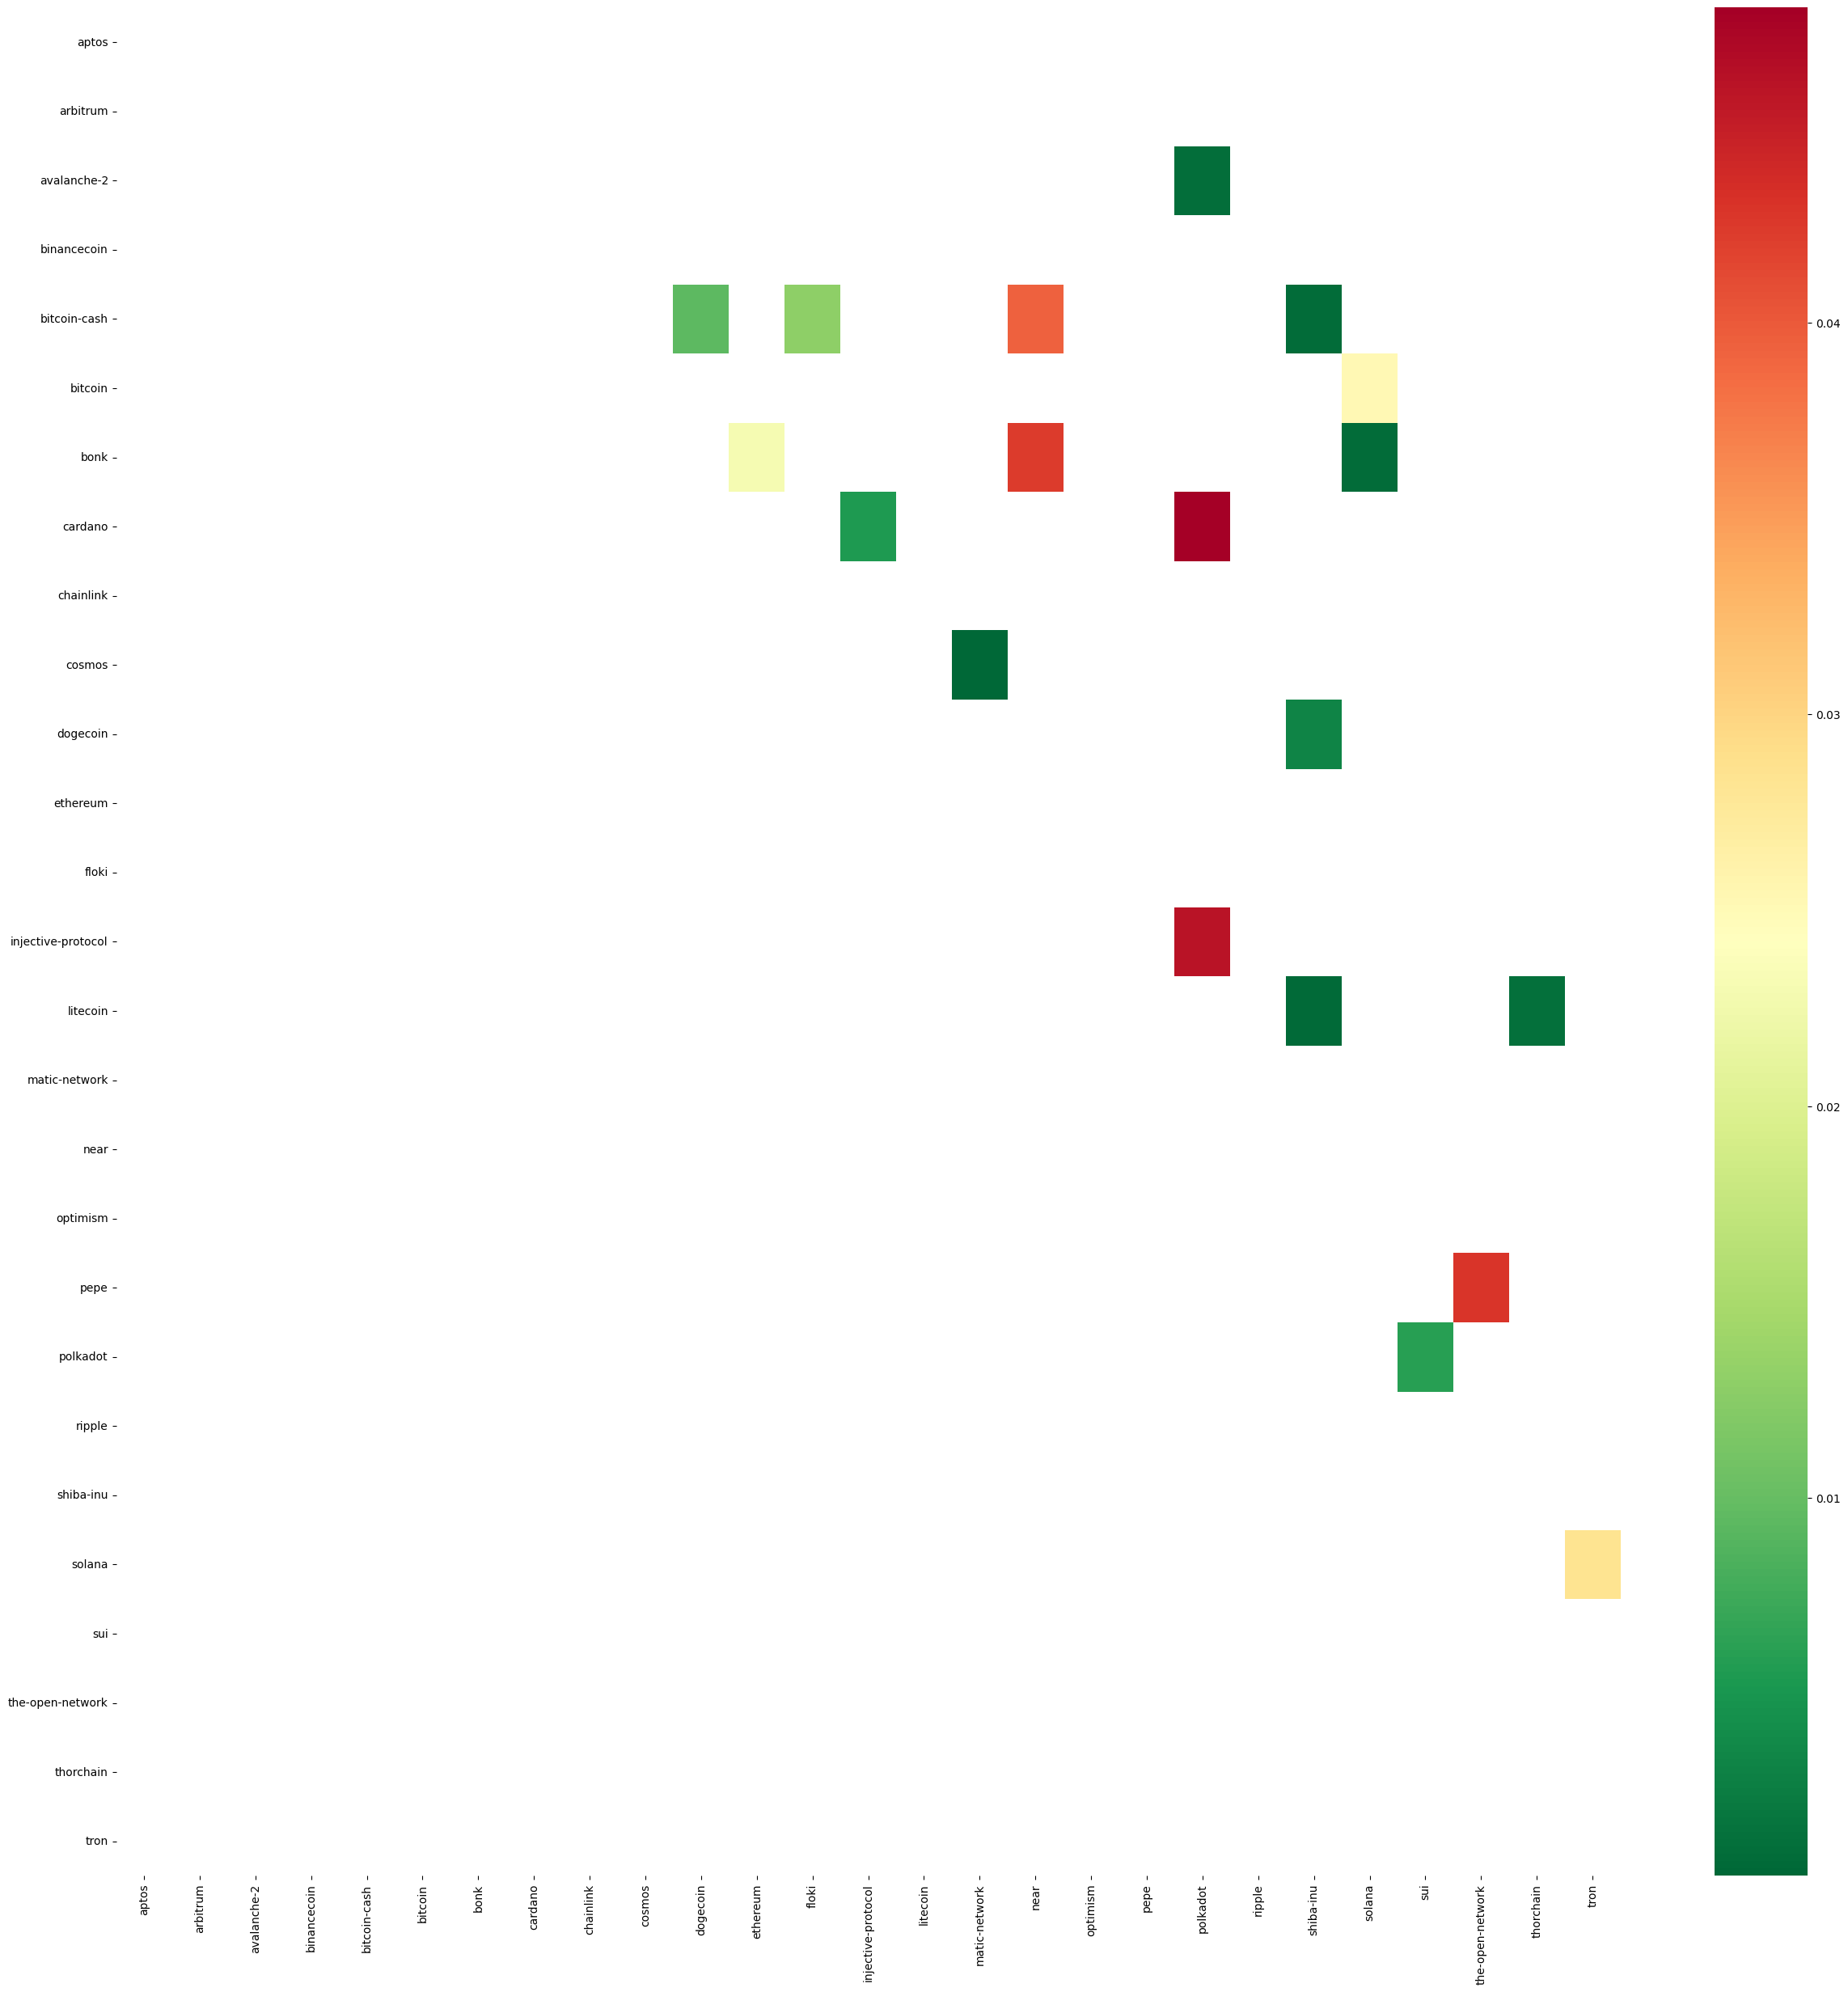

In [31]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
# run pairwise cointegration test to identify pairs
def cointegrated_pairs(df):
    n = df.shape[1]
    scores = np.zeros((n, n))
    p_values = np.ones((n, n))
    tickers = df.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = df[tickers[i]]
            S2 = df[tickers[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            scores[i, j] = score
            p_values[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((tickers[i], tickers[j]))
    return(scores, p_values, pairs)
    

scores, p_values, pairs = cointegrated_pairs(df_prices_pivot[:, 1:])

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(p_values, xticklabels=df_prices_pivot.columns[1:], yticklabels=df_prices_pivot.columns[1:], cmap='RdYlGn_r' 
                , mask = (p_values >= 0.05)
                )

pairs

#### Strategy

While we can pick any of the pairs, I will select BCH and DOGE due to the ratio being somewhat more volatile and us being able to enter more trades. The steps to create the strategy will be the same for any selected pairs. Given that prices are generally non-stationary, we will be looking at the ratio between the respective asset prices.

In [32]:
x_asset = 'bitcoin-cash'
y_asset = 'dogecoin'

print(f"{x_asset} price data: p-value of {adfuller(df_prices_pivot[x_asset])[1]}, non-stationary")
print(f"{y_asset} price data: p-value of {adfuller(df_prices_pivot[y_asset])[1]}, non-stationary")


bitcoin-cash price data: p-value of 0.4499455695985918, non-stationary
dogecoin price data: p-value of 0.5163451017366312, non-stationary


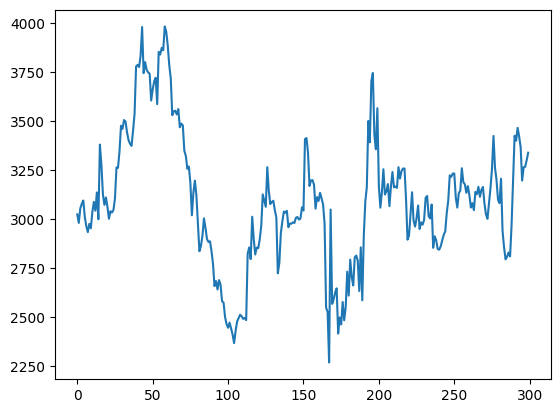

In [33]:
Y = df_prices_pivot[y_asset].to_numpy()
X = df_prices_pivot[x_asset].to_numpy()

ratio = X/Y

plt.plot(ratio)
plt.show()

It appears that the ratio moves around some value. If we plot the mean, it becomes a little bit more evident.

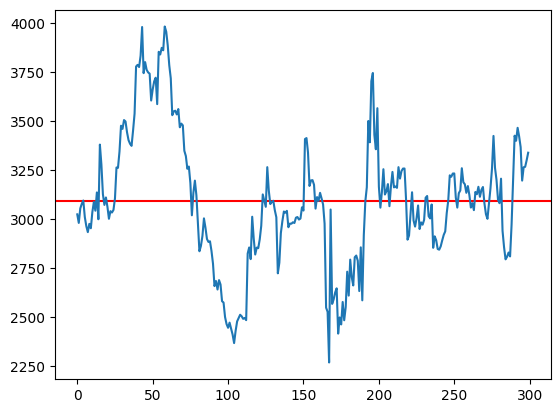

In [34]:
plt.axhline(y=np.mean(ratio), color='r', linestyle='-')
plt.plot(ratio)
plt.show()

#### Entry & Exit Conditions

The idea behind the pair strategy is to short the ratio if it is trading above a certain value and long it if it falls below. To quantify this, we can use the standard score which refers to the number of standard deviations a certain value is from the mean.

$$z = \frac{X-\mu}{\sigma}$$

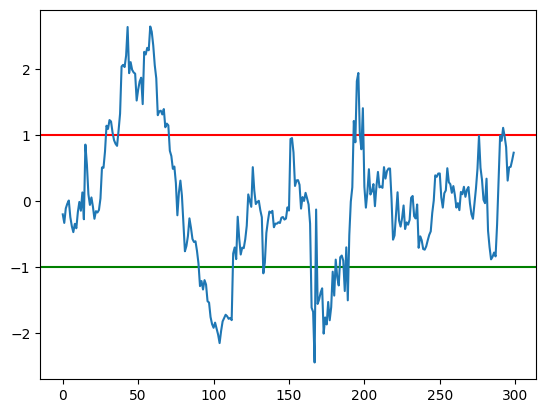

In [35]:
z = (ratio - np.mean(ratio))/np.std(ratio)

plt.axhline(y=1, color='r', linestyle='-')
plt.axhline(y=-1, color='g', linestyle='-')
plt.plot(z)
plt.show()

Whenever the ratio is above 1, this implies that we want to short the ratio and whenever it falls below -1, we long it.

#### Backtesting


The above example has a strong bias due to us looking ahead at values. The actual strategy needs to constantly update the rolling statistics. Given that our data set is somewhat limited, ideally, we would have a larger sample size to have more robust signals. This could either be accomplished by taking data from either a larger time frame or on a lower resolution.

In [36]:
df_prices_assets = df_prices_pivot[['timestamp', x_asset, y_asset]]

# calculate the ratio
df_prices_assets = df_prices_assets.with_columns(
    (pl.col(x_asset)/pl.col(y_asset)).alias('ratio')
)

Next, in order to calculate the z-scores, we need to have a rolling mean and standard deviations. To increase the number of trades (for the sake of this example), we will enter/exit based on z-scores of +/- 0.5.

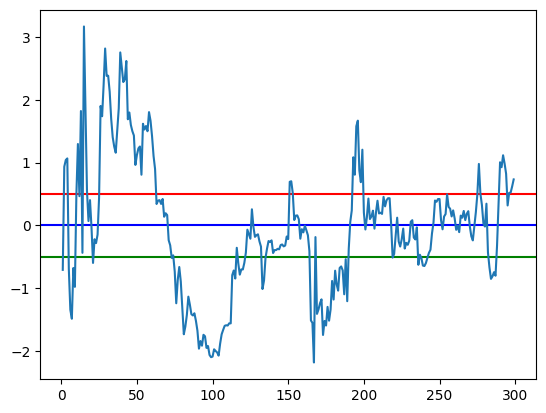

In [37]:
df_prices_assets = (df_prices_assets
  .with_columns(
    timestamp = pl.col('timestamp').cast(pl.Datetime),
    ratio_rolling_mean = pl.col('ratio').rolling_mean(window_size=df_prices_assets.height, min_periods=1, center=False),
    ratio_rolling_std = pl.col('ratio').rolling_std(window_size=df_prices_assets.height, min_periods=1, center=False)
 ).with_columns(
    expanding_z = ((pl.col('ratio')-pl.col('ratio_rolling_mean'))/pl.col('ratio_rolling_std'))
 )
)

plt.axhline(y=0.5, color='r', linestyle='-')
plt.axhline(y=-0.5, color='g', linestyle='-')
plt.axhline(y=0, color='b', linestyle='-')
plt.plot(df_prices_assets['expanding_z'])
plt.show()

In [38]:
def backtest(df: pl.DataFrame, entry=0.5, exit=-0.5):
    col_names = ['timestamp', y_asset, x_asset, 'expanding_z']
    indices = [df.get_column_index(a) for a in col_names]
    cur = None
    trades = []
    counter = 0
    for row in df.iter_rows():
        counter += 1
        ts, y_price, x_price, z = np.array(row)[indices]
        # if no position open
        if not cur:
            if z >= entry:
                cur = 'short'
                trades.append([ts, 'short', x_price, y_price, z])
            elif z <= exit:
                cur = 'long'
                trades.append([ts, 'long', x_price, y_price, z])
        
        # else a position is open
        else:
            # if we are short the ratio
            if cur == 'short':
                # close position if z is below 0
                if z <= 0:
                    cur = None
                    trades.append([ts, 'close short', x_price, y_price, z])
            else:
                # close position if z is above 0
                if z >= 0:
                    cur = None
                    trades.append([ts, 'close long', x_price, y_price, z])
    # fill with price
    if cur:
        if cur == 'short':
            trades.append([ts, 'close short', x_price, y_price, z])
        else:
            trades.append([ts, 'close long', x_price, y_price, z])
    df_trades = pl.DataFrame(trades, strict=False, orient='row')
    df_trades.columns = ['time', 'descr', x_asset, y_asset, 'z']
    return df_trades
                    
df_trades = backtest(df_prices_assets[1:,:])

df_trades

time,descr,bitcoin-cash,dogecoin,z
datetime[μs],str,f64,f64,f64
2023-08-13 00:00:00,"""long""",228.588776,0.076696,-0.707111
2023-08-14 00:00:00,"""close long""",228.387161,0.074778,0.934684
2023-08-15 00:00:00,"""short""",230.119965,0.074764,1.041103
2023-08-18 00:00:00,"""close short""",183.800461,0.061057,-0.694186
2023-08-19 00:00:00,"""long""",187.278076,0.063189,-1.341707
…,…,…,…,…
2024-07-18 00:00:00,"""close short""",375.314667,0.121819,-0.017909
2024-07-21 00:00:00,"""long""",400.369965,0.140121,-0.67
2024-07-29 00:00:00,"""close long""",416.500977,0.130002,0.357568


Next, we can calculate the returns of the strategy as a combination of the short leg and long leg.

In [39]:
df_trades = df_trades.with_columns(
    x_dif = pl.col(x_asset).pct_change(1),
    y_dif = pl.col(y_asset).pct_change(1)
).with_columns(
    trade_pnl = pl.when(pl.col('descr') == 'close short').then(-pl.col('x_dif')+pl.col('y_dif')).when(pl.col('descr') == 'close long').then(pl.col('x_dif')-pl.col('y_dif'))
)

f"Overall PnL of the strategy without taking fees into account {df_trades['trade_pnl'].cum_sum()[-1]}"

'Overall PnL of the strategy without taking fees into account 1.4610700296563297'

#### Metrics

Compared to BTC, which has a return of 109%, the strategy has returns of 140% (with fees). While there were other pairs that performed well (such as BTC-SOL at over 400%), I decided to pick an example where a sufficient number of trades occurred. 

To truly evaluate the performance, we would need more data at a better resolution.



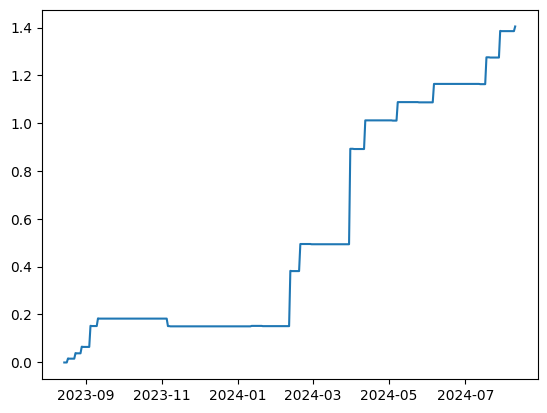

descr,bitcoin-cash,dogecoin,z,x_dif,y_dif,trade_pnl,date,cumulative_pnl
str,f64,f64,f64,f64,f64,f64,date,f64
"""short""",230.119965,0.074764,1.041103,0.007587,-0.000179,-0.001,2023-08-15,-0.001
null,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-16,-0.001
null,0.0,0.0,0.0,0.0,0.0,0.0,2023-08-17,-0.001
"""close short""",183.800461,0.061057,-0.694186,-0.201284,-0.183337,0.016948,2023-08-18,0.015948
"""long""",187.278076,0.063189,-1.341707,0.018921,0.034913,-0.001,2023-08-19,0.014948
…,…,…,…,…,…,…,…,…
null,0.0,0.0,0.0,0.0,0.0,0.0,2024-08-06,1.385465
null,0.0,0.0,0.0,0.0,0.0,0.0,2024-08-07,1.385465
null,0.0,0.0,0.0,0.0,0.0,0.0,2024-08-08,1.385465


In [40]:
from datetime import timedelta, date

df_range = pl.DataFrame(pl.date_range(date(2023, 8, 15), date(2024, 8, 10), timedelta(days=1), eager=True).alias('date'))

df_trades = df_trades.with_columns(
    # fees
    trade_pnl = pl.col('trade_pnl') - (2*0.0005)
).with_columns(
    trade_pnl = pl.col('trade_pnl').fill_null(2*-0.0005)
)

# filter date to join columns
df_trades = df_trades.with_columns(
    time = pl.col('time').dt.date()
)

df_full_range = df_trades.join(df_range, left_on='time', right_on='date', how='right')

# fill zeroes
df_full_range = df_full_range.fill_null(0)
df_full_range = df_full_range.with_columns(
    cumulative_pnl = df_full_range['trade_pnl'].cum_sum()
)

# plot pnl
plt.plot(df_full_range['date'], df_full_range['cumulative_pnl'])
plt.show()

df_full_range

#### Performance

We can calculate the sharpe ratio using the following formula:

$$Sharpe Ratio = \frac{\text{annualized return strategy} - \text{risk-free return}}{\text{std dev return strategy}}$$

Given the nature of the strategy and the long holding periods, Sharpe is not saying that much about the success of the strategy itself. Nonetheless, it is better than nothing.

In [42]:
def sharpe_ratio(returns: pl.DataFrame, N, rf):
    mean = returns.mean() * N - rf
    sigma = returns.std() * np.sqrt(N)
    return mean/sigma

# depends whether we decide that there are 255 or 365 trading days, assuming risk-free rate of 5% which is around treasury yield (https://www.bloomberg.com/markets/rates-bonds/government-bonds/us)
print(f"Sharpe Ratio of: {sharpe_ratio(df_full_range['trade_pnl'], 365, 0.05)}")

# export returns for risk calculations
df_full_range.write_csv('./data/strat/returns.csv')

# export price table
df_prices_pivot.write_csv('./data/strat/price_data.csv')

Sharpe Ratio of: 2.551706385878749


### Improvements

#### Data

Ideally, there would be more data to backtest on. Similarly, trading on different ticks (e.g., 15 min) could provide better signals. Due to the limited data set, there also does not exist information on the funding rate, open interest and other indicators that could enhance our strategy.

#### Strategy

The strategy here identifies cointegrated pairs and then leverages the mean-reverting properties by longing/shorting the ratio of the two assets at hand. One could further trade on the spreads. This could be accomplished by estimating the coefficients through a rolling regression. 

Similarly, one could further take the Hurst exponent into account and identify how strongly a time series is mean reverting and what the half life time is. 

#### Fees & Slippage

In the example, both fees and slippage were estimated. Naturally, when a strategy is taken live, both of these will differ drastically from the hypothetical values. Similarly, no funding rate payments were considered. Given the large holding periods, it would therefore be also significant.
